In [ ]:
!pip install requests beautifulsoup4 langdetect

In [ ]:
!pip install seaborn

In [645]:
!pip install persiantools


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [75]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------- ----------------------------- 2.6/9.8 MB 16.4 MB/s eta 0:00:01
   ------------------------- -------------- 6.3/9.8 MB 16.1 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 16.3 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 15.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   --- ------------------------------------ 3.7/41.0 MB 18.1 MB/s eta 0:00:03
   ------ --------------------------------- 6.8/41.0 MB 16.5 MB/s eta 0:00:03
   ---------- ----------------------------- 10.5/41.0 MB 17.1 MB/s eta 0:00:02
   ------------- -------------------------- 14.2/41.0 MB 17.4 MB/s eta 0:00:02
   ----------------- ---------------------- 17.8/41.0 MB 17.6 MB/s eta 0:00:02
   -------------------- ------------------- 21.2/41.0 MB 17.2 MB/s eta 0:00:02
   ---------------------- ----------------- 22.8/41.0 MB 16.0 MB/s eta 0:00:02
  


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [413]:
import requests
from bs4 import BeautifulSoup
from langdetect import detect
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from persiantools.jdatetime import JalaliDate
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

In [92]:
root_dir = r'C:\Users\ssasanapuri\Downloads\CalibrationFilesAsOfMay22\cal-reports'

In [93]:
total_folders_count = 0
total_html_files_count = 0
for folder in os.listdir(root_dir):
    total_folders_count+=1
    folder_path = os.path.join(root_dir, folder)
    for file in os.listdir(folder_path):
        if file.lower().endswith('.html'):
            total_html_files_count+=1
print('total_folders:', total_folders_count)
print('total_html_files:', total_html_files_count)


total_folders: 3254
total_html_files: 13811


In [94]:
non_english_files = {}
non_english_count = 0

# Loop over folders directly inside cal-reports
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)

    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith('.html'):
                file_path = os.path.join(folder_path, file)
                try:
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        soup = BeautifulSoup(f, 'html.parser')
                        text = soup.get_text(strip=True)
                        sample_text = text[:1000]
                        detected_lang = detect(sample_text)

                        if detected_lang != 'en':
                            if folder not in non_english_files:
                                non_english_files[folder] = []
                            non_english_files[folder].append(file)
                            non_english_count += 1
                            if non_english_count % 25 == 0:
                                print(f"[DEBUG] {non_english_count}: Folder '{folder}' - File '{file}' - Language: {detected_lang}")

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Output the result
print("Folders with non-English HTML files:")
print(json.dumps(non_english_files, indent=2))

# Save if needed
with open('non_english_files.json', 'w', encoding='utf-8') as f:
    json.dump(non_english_files, f, indent=2)


[DEBUG] 25: Folder '1004160' - File '1716912328888-4645723133313024-VuSitu_Calibration_1004160_2024-05-28.html' - Language: fr
[DEBUG] 50: Folder '1004160' - File '1741635470210-6406701028605952-VuSitu_Calibration_1004160_2025-03-10.html' - Language: fr
[DEBUG] 75: Folder '1018837' - File '1734440482656-5712222443405312-VuSitu_Calibration_1018837_2024-12-17.html' - Language: fr
[DEBUG] 100: Folder '1027354' - File '1739540113570-5278447899312128-VuSitu_Calibracio╠ün_1027354_2025-02-14.html' - Language: es
[DEBUG] 125: Folder '1040125' - File '1744878875339-6293870165950464-VuSitu_Calibration_1040125_2025-04-17.html' - Language: fr
[DEBUG] 150: Folder '1053649' - File '1742893949306-5463740120104960-VuSitu_Calibrazione_1053649_2025-03-25.html' - Language: it
[DEBUG] 175: Folder '1066431' - File '1733414621427-5328893852385280-VuSitu_Calibracio╠ün_1066431_2024-12-05.html' - Language: es
[DEBUG] 200: Folder '1077453' - File '1725427511622-6072217423970304-VuSitu_Calibration_1077453_2024-0

In [95]:
non_english_count

1274

In [96]:
len(non_english_files.keys())

452

In [97]:
file_count = 0
for value in non_english_files.values():
    file_count+=len(value)
print(file_count)

1274


In [98]:
len(non_english_files.keys())/total_folders_count

0.1389059618930547

In [99]:
non_english_count/total_html_files_count

0.09224531170805879

In [100]:
parsed_tables = {}

# Same loop to run through folders
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)

    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith('.html'):
                file_path = os.path.join(folder_path, file)

                try:
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        soup = BeautifulSoup(f, 'html.parser')

                    tables = soup.find_all('table')
                    all_tables = []

                    for table in tables:
                        rows = table.find_all('tr')
                        table_data = []

                        for row in rows:
                            cells = [td.get_text(strip=True) for td in row.find_all('td')]
                            if cells:
                                table_data.append(cells)

                        if table_data:
                            caption_tag = table.find('caption')
                            caption_text = caption_tag.get_text(strip=True) if caption_tag else "No caption"
                            all_tables.append({
                                "caption": caption_text,
                                "rows": table_data
                            })

                    # Only store if there was at least one non-empty table
                    if all_tables:
                        match = re.search(r'cal-reports[/\\](.*?).html', file_path)
                        file_identifier = match.group(1) if match else file
                        parsed_tables[file_identifier] = all_tables

                except Exception as e:
                    print(f"[ERROR] Failed to process {file_path}: {e}")


with open("parsed_html_tables.json", "w", encoding="utf-8") as f:
    json.dump(parsed_tables, f, indent=2, ensure_ascii=False)


In [101]:
# Previewing 3 samples
for file_id, tables in list(parsed_tables.items())[3:7]:
    print(f"\nFile: {file_id} | Tables: {len(tables)}")
    for t in tables:
        print(f"  Caption: {t['caption']}")
        for row in t['rows']:
            print("   ", row)


File: 1001787\1716227632465-4778236262612992-VuSitu_Calibration_1001787_2024-05-20 | Tables: 3
  Caption: No caption
    ['Instrument', 'Aqua TROLL 100']
    ['Numéro de série', '1001787']
    ['Créé', '20/05/2024']
  Caption: Capteur
    ['Capteur', 'Conductivité']
    ['Numéro de série', '1001787']
    ['Dernier étalonnage', '20/05/2024']
  Caption: Détails de l'étalonnage
    ['Décalage', '0,00 µS/cm']
    ['Constante de cellule', '0,992']
    ['Température de référence', '20,00 °C']
    ['Facteur de Conversion TDS (ppm)', '0,65']

File: 1001787\1725617384884-5973895707230208-VuSitu_Calibration_1001787_2024-09-06 | Tables: 3
  Caption: No caption
    ['Instrument', 'Aqua TROLL 100']
    ['Numéro de série', '1001787']
    ['Créé', '6/09/2024']
  Caption: Capteur
    ['Capteur', 'Conductivité']
    ['Numéro de série', '1001787']
    ['Dernier étalonnage', '6/09/2024']
  Caption: Détails de l'étalonnage
    ['Décalage', '0,00 µS/cm']
    ['Constante de cellule', '0,947']
    ['Tempéra

In [102]:
sample = list(parsed_tables.items())[8]
sample

('1001834\\1743483838473-6587664132276224-VuSitu_Calibration_1001834_2025-04-01',
 [{'caption': 'No caption',
   'rows': [['Instrument', 'Aqua TROLL 500'],
    ['Serial Number', '1001834'],
    ['Created', '01/04/2025']]},
  {'caption': 'Sensor',
   'rows': [['Sensor', 'Turbidity'],
    ['Serial Number', '1187093'],
    ['Last Calibrated', '01/04/2025']]},
  {'caption': 'Calibration Details',
   'rows': [['Slope', '1'], ['Offset', '0.94 NTU']]},
  {'caption': 'Calibration Point 1',
   'rows': [['Pre Measurement', '9.13 NTU'],
    ['Post Measurement', '10.00 NTU']]},
  {'caption': 'Sensor',
   'rows': [['Sensor', 'Conductivity'],
    ['Serial Number', '1043728'],
    ['Last Calibrated', '01/04/2025']]},
  {'caption': 'Calibration Details',
   'rows': [['TDS Conversion Factor (ppm)', '0.65'],
    ['Cell Constant', '0.699'],
    ['Offset', '0.00 µS/cm'],
    ['Reference Temperature', '25.00 °C']]},
  {'caption': 'Pre Measurement',
   'rows': [['Actual Conductivity', '116,132 µS/cm'],
    

In [103]:
list(non_english_files.keys())

['1000325',
 '1001540',
 '1001787',
 '1001881',
 '1002137',
 '1004063',
 '1004160',
 '1005570',
 '1009892',
 '1015890',
 '1015899',
 '1017586',
 '1017587',
 '1017591',
 '1017594',
 '1018837',
 '1020158',
 '1023986',
 '1024751',
 '1026421',
 '1026423',
 '1026424',
 '1026431',
 '1026455',
 '1026480',
 '1026501',
 '1027354',
 '1035118',
 '1040125',
 '1040454',
 '1042426',
 '1043355',
 '1046779',
 '1048303',
 '1048413',
 '1053649',
 '1054126',
 '1054133',
 '1054139',
 '1058039',
 '1059060',
 '1066431',
 '1066435',
 '1066436',
 '1068400',
 '1068416',
 '1068646',
 '1071899',
 '1076916',
 '1077453',
 '1084254',
 '1084256',
 '1084260',
 '1084441',
 '1084694',
 '1089521',
 '1090119',
 '1090547',
 '1090552',
 '1090566',
 '1090568',
 '1096550',
 '1096961',
 '1100040',
 '1101848',
 '1101870',
 '1102870',
 '1102894',
 '1103042',
 '1103104',
 '1103536',
 '1103851',
 '1103856',
 '1105664',
 '1106113',
 '1107352',
 '1107361',
 '1109156',
 '1109777',
 '1114560',
 '1114962',
 '1115278',
 '1115453',
 '11

In [104]:
non_english_folders = list(non_english_files.keys())

def is_non_english(file_id):
    folder = file_id.split("\\", 1)[0]
    return folder in non_english_folders


In [105]:
non_english_folders

['1000325',
 '1001540',
 '1001787',
 '1001881',
 '1002137',
 '1004063',
 '1004160',
 '1005570',
 '1009892',
 '1015890',
 '1015899',
 '1017586',
 '1017587',
 '1017591',
 '1017594',
 '1018837',
 '1020158',
 '1023986',
 '1024751',
 '1026421',
 '1026423',
 '1026424',
 '1026431',
 '1026455',
 '1026480',
 '1026501',
 '1027354',
 '1035118',
 '1040125',
 '1040454',
 '1042426',
 '1043355',
 '1046779',
 '1048303',
 '1048413',
 '1053649',
 '1054126',
 '1054133',
 '1054139',
 '1058039',
 '1059060',
 '1066431',
 '1066435',
 '1066436',
 '1068400',
 '1068416',
 '1068646',
 '1071899',
 '1076916',
 '1077453',
 '1084254',
 '1084256',
 '1084260',
 '1084441',
 '1084694',
 '1089521',
 '1090119',
 '1090547',
 '1090552',
 '1090566',
 '1090568',
 '1096550',
 '1096961',
 '1100040',
 '1101848',
 '1101870',
 '1102870',
 '1102894',
 '1103042',
 '1103104',
 '1103536',
 '1103851',
 '1103856',
 '1105664',
 '1106113',
 '1107352',
 '1107361',
 '1109156',
 '1109777',
 '1114560',
 '1114962',
 '1115278',
 '1115453',
 '11

In [106]:
non_english_folders.append('1070494')

In [107]:
non_english_folders

['1000325',
 '1001540',
 '1001787',
 '1001881',
 '1002137',
 '1004063',
 '1004160',
 '1005570',
 '1009892',
 '1015890',
 '1015899',
 '1017586',
 '1017587',
 '1017591',
 '1017594',
 '1018837',
 '1020158',
 '1023986',
 '1024751',
 '1026421',
 '1026423',
 '1026424',
 '1026431',
 '1026455',
 '1026480',
 '1026501',
 '1027354',
 '1035118',
 '1040125',
 '1040454',
 '1042426',
 '1043355',
 '1046779',
 '1048303',
 '1048413',
 '1053649',
 '1054126',
 '1054133',
 '1054139',
 '1058039',
 '1059060',
 '1066431',
 '1066435',
 '1066436',
 '1068400',
 '1068416',
 '1068646',
 '1071899',
 '1076916',
 '1077453',
 '1084254',
 '1084256',
 '1084260',
 '1084441',
 '1084694',
 '1089521',
 '1090119',
 '1090547',
 '1090552',
 '1090566',
 '1090568',
 '1096550',
 '1096961',
 '1100040',
 '1101848',
 '1101870',
 '1102870',
 '1102894',
 '1103042',
 '1103104',
 '1103536',
 '1103851',
 '1103856',
 '1105664',
 '1106113',
 '1107352',
 '1107361',
 '1109156',
 '1109777',
 '1114560',
 '1114962',
 '1115278',
 '1115453',
 '11

In [108]:
def flatten_calibration_data(file_id, table_list):
    row_data = {}
    current_sensor = None
    sensor_prefix = ""

    for i, table in enumerate(table_list):
        caption = table.get('caption', 'No caption').strip()
        rows = table.get('rows', [])

        # Instrument-level table (first table)
        if i == 0:
            for key, value in rows:
                row_data[key] = value
            continue

        # Sensor table → marks start of new sensor block
        if caption.lower() == 'sensor':
            current_sensor = None
            last_calibrated = None
            serial_number = None

            for key, value in rows:
                if key.lower() == 'sensor':
                    current_sensor = value.replace(" ", "_")  # e.g., pH/ORP → pH_ORP
                elif key.lower() == 'last calibrated':
                    last_calibrated = value
                elif key.lower() == 'serial number':
                    serial_number = value

            if current_sensor:
                if last_calibrated:
                    row_data[f"{current_sensor}_Last_Calibrated_Date"] = last_calibrated
                if serial_number:
                    row_data[f"{current_sensor}_Serial_Number"] = serial_number

            # Set sensor_prefix for following tables
            sensor_prefix = current_sensor if current_sensor else f"UnknownSensor_{i}"
            continue

        # Other calibration tables under current sensor
        if current_sensor:
            for key, value in rows:
                col_name = f"{sensor_prefix}_{caption}_{key}".replace(" ", "_")
                row_data[col_name] = value

    # Add File_ID, Folder, File_Name
    folder, file_name = file_id.split("\\", 1)
    row_data["File_ID"] = file_id
    row_data["Folder"] = folder
    row_data["File_Name"] = file_name

    return row_data


In [109]:
flat_rows = []

for file_id, tables in parsed_tables.items():
    if is_non_english(file_id):
        print(f"[SKIP] Non-English folder: {file_id}")
        continue
    flat_row = flatten_calibration_data(file_id, tables)
    flat_rows.append(flat_row)


df = pd.DataFrame(flat_rows)


df.to_excel("flattened_calibration_data_dates_sensor_serial_number.xlsx", index=False)
print("✅ Excel file saved: flattened_calibration_data_dates_sensor_serial_number.xlsx")

[SKIP] Non-English folder: 1000325\1718195361596-4567583857967104-VuSitu_µáíσçå_1000325_2024-06-12
[SKIP] Non-English folder: 1001540\1737032840712-5760434579570688-VuSitu_Calibration_1001540_2025-01-16
[SKIP] Non-English folder: 1001540\1738150072697-5490168074993664-VuSitu_Calibration_1001540_2025-01-29
[SKIP] Non-English folder: 1001787\1716227632465-4778236262612992-VuSitu_Calibration_1001787_2024-05-20
[SKIP] Non-English folder: 1001787\1725617384884-5973895707230208-VuSitu_Calibration_1001787_2024-09-06
[SKIP] Non-English folder: 1001787\1741618188359-4692604343943168-VuSitu_Calibration_1001787_2025-03-10
[SKIP] Non-English folder: 1001881\1716227316927-5752154859372544-VuSitu_Calibration_1001881_2024-05-20
[SKIP] Non-English folder: 1001881\1725617698709-6511096291524608-VuSitu_Calibration_1001881_2024-09-06
[SKIP] Non-English folder: 1001881\1741616663599-6247287931928576-VuSitu_Calibration_1001881_2025-03-10
[SKIP] Non-English folder: 1002137\1727761448066-6067472395272192-VuS

#### Reading excel

In [246]:
df_path = r"C:\Users\ssasanapuri\PyCharmMiscProject\flattened_calibration_data_dates_sensor_serial_number.xlsx"
df = pd.read_excel(df_path, sheet_name = 'df_master')

#### pH values cleaning

In [247]:
df.columns = [col.replace("pH/ORP_ORP", "ORP") if col.startswith("pH/ORP_ORP") else col for col in df.columns]

In [248]:
df.columns = [col.replace("pH/ORP", "pH_org") if col.startswith("pH/ORP") else col for col in df.columns]

In [249]:
def fill_duplicate_column_pairs(df, column_index_pairs):
    cols_to_drop = []

    for idx1, idx2 in column_index_pairs:
        df.iloc[:, idx1] = df.iloc[:, idx1].fillna(df.iloc[:, idx2])
    return df


In [250]:
column_pairs = [
    (20, 229),
    (21, 231),
    (22, 232),
    (23, 233),
    (46, 234),
    (47, 235),
    (48, 236),
    (53, 237),
    (54, 238),
    (55, 239),
    (28, 240),
    (29, 241),
    (56, 242),
    (57, 243),
    (117, 230)
    # add all 15 index pairs here
]

In [251]:
df = fill_duplicate_column_pairs(df, column_pairs)

In [252]:
col_index = list(range(20, 30)) + list(range(46, 49)) + list(range(53, 58)) + [117] + list(range(229, 244))
pH_columns = [col for col in df.columns if re.search(r"^pH_.*", col)]

folder_nums_ph_eu = [1003230, 1005719, 1021234, 1021266, 1033030, 1033052, 1033090, 1033135, 1033165, 1044849, 1048181, 1048262, 1048291, 1052449, 1070980, 1087333, 1087334, 1087336, 1087337, 1087366, 1087368, 1087382, 1087385, 1087395, 1103264, 1104834, 1109172, 1114649, 1115291, 1121778, 1122921, 1126631, 1126636, 1126638, 1126641, 1126645, 1126649, 1126656, 1126660, 1126661, 1126665, 1130154, 1130164, 1132476, 1144665, 1167458, 1183492, 1203243, 1209499, 424633, 431662, 544406, 599874, 605064, 617094, 621216, 636894, 636946, 637000, 637029, 657735, 660051, 660161, 676884, 676913, 677091, 677099, 677137, 677162, 677314, 677627, 683586, 690459, 707665, 709755, 723930, 724015, 724035, 724101, 724731, 728128, 732247, 745641, 747404, 747436, 782643, 782660, 782670, 824904, 824939, 824979, 825043, 843650, 843656, 843739, 843740, 843741, 843955, 844693, 869431, 869453, 869707, 869713, 871256, 890814, 890824, 890830, 890833, 891035, 897108, 913967, 920319, 937683, 955779, 956535, 960330, 985627, 985650, 987077, 994859]

In [253]:
pH_columns[1:19]

['pH_org_Calibration_Point_1_pH_of_Buffer',
 'pH_org_Calibration_Point_1_pH_mV',
 'pH_org_Calibration_Point_1_Temperature',
 'pH_org_Pre_Measurement_pH',
 'pH_org_Pre_Measurement_pH_mV',
 'pH_org_Post_Measurement_pH',
 'pH_org_Post_Measurement_pH_mV',
 'pH_org_Slope_and_Offset_1_Slope',
 'pH_org_Slope_and_Offset_1_Offset',
 'pH_org_Calibration_Point_2_pH_of_Buffer',
 'pH_org_Calibration_Point_2_pH_mV',
 'pH_org_Calibration_Point_2_Temperature',
 'pH_org_Calibration_Point_3_pH_of_Buffer',
 'pH_org_Calibration_Point_3_pH_mV',
 'pH_org_Calibration_Point_3_Temperature',
 'pH_org_Slope_and_Offset_2_Slope',
 'pH_org_Slope_and_Offset_2_Offset',
 'pH_org_Calibration_Details_Total_Calibration_Points']

In [254]:
df['Folder'] = df['Folder'].astype(str)

folder_set = set(str(f) for f in folder_nums_ph_eu)

def replace_commas(val):
    if isinstance(val, str):
        return val.replace(',', '.')
    return val


pH_indices = [df.columns[:229].get_loc(col) for col in pH_columns[:19]]

mask = df['Folder'].isin(folder_set)

for idx in pH_indices:
    df.iloc[mask.values, idx] = df.iloc[mask.values, idx].apply(replace_commas)

In [255]:
### Removing commas in remaining rows
def remove_commas(val):
    if isinstance(val, str):
        return val.replace(',', '')
    return val

def remove_non_numeric(val):
    if isinstance(val, str):
        return re.sub(r'-(?=\D)|[^0-9.\-]', '', val)
    return val


In [256]:
for idx in pH_indices[1:]:
    df.iloc[:, idx] = df.iloc[:, idx].apply(remove_commas)
    df.iloc[:, idx] = df.iloc[:, idx].apply(remove_non_numeric)


In [257]:
pH_indices

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 46, 47, 48, 53, 54, 55, 56, 57, 117]

In [258]:
indexes_to_drop = list(range(229, 244))
# indexes_to_drop

columns_to_drop = df.columns[indexes_to_drop]
df = df.drop(columns=columns_to_drop)

In [259]:
for idx in pH_indices[1:]:  # Skip the first entry
    df.iloc[:, idx] = df.iloc[:, idx].astype(float)

In [427]:
# output_path = r"C:\Users\ssasanapuri\Downloads\CalibrationFilesAsOfMay22\tRANFORMED\transformed_data.xlsx"
# df.to_excel(output_path, index=True)

In [260]:
df.columns[pH_indices]

Index(['pH_org_Last_Calibrated_Date',
       'pH_org_Calibration_Point_1_pH_of_Buffer',
       'pH_org_Calibration_Point_1_pH_mV',
       'pH_org_Calibration_Point_1_Temperature', 'pH_org_Pre_Measurement_pH',
       'pH_org_Pre_Measurement_pH_mV', 'pH_org_Post_Measurement_pH',
       'pH_org_Post_Measurement_pH_mV', 'pH_org_Slope_and_Offset_1_Slope',
       'pH_org_Slope_and_Offset_1_Offset',
       'pH_org_Calibration_Point_2_pH_of_Buffer',
       'pH_org_Calibration_Point_2_pH_mV',
       'pH_org_Calibration_Point_2_Temperature',
       'pH_org_Calibration_Point_3_pH_of_Buffer',
       'pH_org_Calibration_Point_3_pH_mV',
       'pH_org_Calibration_Point_3_Temperature',
       'pH_org_Slope_and_Offset_2_Slope', 'pH_org_Slope_and_Offset_2_Offset',
       'pH_org_Calibration_Details_Total_Calibration_Points'],
      dtype='object')

In [243]:
def plot_column_distribution(df, column_name, bins=30):
    plt.figure(figsize=(8, 5))
    df[column_name].dropna().astype(float).hist(bins=bins, edgecolor='black')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
for idx in pH_indices[1:]:
    plot_column_distribution(df, df.columns[idx])

In [261]:
len(df.columns)

254

#### All Dates formatting

In [262]:
dates_columns = [col for col in df.columns if re.search(r"_Date$", col)]
dates_columns


['Conductivity_Last_Calibrated_Date',
 'RDO_Last_Calibrated_Date',
 'pH_org_Last_Calibrated_Date',
 'Turbidity_Last_Calibrated_Date',
 'Pressure_Last_Calibrated_Date',
 'Barometric_Pressure_Last_Calibrated_Date',
 'Pressure_with_Conductivity_Last_Calibrated_Date',
 'Nitrate_Last_Calibrated_Date',
 'Level_Last_Calibrated_Date',
 'Chloride_Last_Calibrated_Date',
 'Ammonium_Last_Calibrated_Date',
 'FDOM_Last_Calibrated_Date',
 'Chlorophyll-a_Last_Calibrated_Date',
 'Fluorescein_WT_Last_Calibrated_Date',
 'BGA-PC_Last_Calibrated_Date',
 'BGA-PE_Last_Calibrated_Date',
 'Rhodamine_WT_Last_Calibrated_Date',
 'Crude_Oil_Last_Calibrated_Date',
 'ORP_Last_Calibrated_Date']

In [263]:
def convert_date_format(val):
    if isinstance(val, str):
        parts = val.split('/')
        if len(parts) >= 3 and len(parts[0]) > 2:
            return f"{parts[1]}/{parts[2]}/{parts[0]}"
    return val


In [264]:
for col in dates_columns:
    df[col] = df[col].str.replace(".", "/", regex=False)
    df[col] = df[col].str.replace("-", "/", regex=False)
    df[col] = df[col].str.replace("/ ", "/", regex=False)
    df[col] = df[col].str.replace("//", "/", regex=False)
    df[col] = df[col].apply(convert_date_format)
    # df[col] = pd.to_datetime(df[col], errors='coerce')

In [265]:
df_dates_master = pd.read_excel(r"C:\Users\ssasanapuri\Downloads\CalibrationFilesAsOfMay22\Date_format_master\date_format.xlsx", sheet_name='Sheet10')

df_dates_master_file_num = pd.read_excel(r"C:\Users\ssasanapuri\Downloads\CalibrationFilesAsOfMay22\Date_format_master\date_format.xlsx", sheet_name='Sheet2')

In [266]:
df = df.merge(df_dates_master[['Serial Number', 'Date Format followed']], on='Serial Number', how='left')
df = df.merge(df_dates_master_file_num[['File_Name', 'Final']], on='File_Name', how='left')

In [267]:
# Correcting inconsistent date formats

def convert_to_us_date(val, fmt=None):
    try:
        if pd.isnull(val):
            return val
        val = str(val).strip()

        if fmt == "Gregory":

            val = val.replace(" AP", "")
            m, d, y = map(int, val.split("/"))
            g_date = JalaliDate(y, m, d).to_gregorian()
            return f"{g_date.month:02d}/{g_date.day:02d}/{g_date.year}"

        if fmt == "Other":
            return pd.to_datetime(val, format="%d/%m/%Y", errors='coerce').strftime("%m/%d/%Y")

        if fmt == "US":
            return pd.to_datetime(val, format="%m/%d/%Y", errors='coerce').strftime("%m/%d/%Y")

    except:
        return val

def normalize_row(row):
    fmt = row.get('Final', None)
    for col in dates_columns:
        row[col] = convert_to_us_date(row[col], fmt)
    return row


In [268]:
df = df.apply(normalize_row, axis=1)

In [269]:
df[df['Serial Number']==701889]

,Instrument,Serial Number,Created,Conductivity_Last_Calibrated_Date,Conductivity_Calibration_Details_TDS_Conversion_Factor_(ppm),Conductivity_Calibration_Details_Cell_Constant,Conductivity_Calibration_Details_Offset,Conductivity_Calibration_Details_Reference_Temperature,Conductivity_Pre_Measurement_Actual_Conductivity,Conductivity_Pre_Measurement_Specific_Conductivity,...,BGA-PC_Concentration_Total_Calibration_Points,Chlorophyll-a_Concentration_Standard_Type,Chlorophyll-a_Concentration_Total_Calibration_Points,BGA-PE_Concentration_Scale_Factor,BGA-PC_Concentration_Scale_Factor,FDOM_FDOM_Concentration_Scale_Factor,FDOM_CDOM_Concentration_Scale_Factor,BGA-PE_Cell_Count_Scale_Factor,Date Format followed,Final
7791,Aqua TROLL 600,701889.0,11/17/1403 AP,02/05/2025,0.65,1.182,0.00 µS/cm,25.00 °C,"7,667.9 µS/cm","7,230.6 µS/cm",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gregory,Gregory
7792,Aqua TROLL 600,701889.0,12/6/1403 AP,02/05/2025,0.65,1.182,0.00 µS/cm,25.00 °C,"7,667.9 µS/cm","7,230.6 µS/cm",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gregory,Gregory
7793,Aqua TROLL 600,701889.0,1/7/1404 AP,03/27/2025,0.65,1.001,0.00 µS/cm,25.00 °C,"9,930.4 µS/cm","9,469.8 µS/cm",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gregory,Gregory


In [270]:
df.iloc[7788:7791, [3,12,20,38,49,58,62,70,87,91]]

,Conductivity_Last_Calibrated_Date,RDO_Last_Calibrated_Date,pH_org_Last_Calibrated_Date,Turbidity_Last_Calibrated_Date,Pressure_Last_Calibrated_Date,Barometric_Pressure_Last_Calibrated_Date,Pressure_with_Conductivity_Last_Calibrated_Date,Nitrate_Last_Calibrated_Date,Level_Last_Calibrated_Date,Chloride_Last_Calibrated_Date
7788,Factory Defaults,08/31/2018,NaN,08/09/2024,Factory Defaults,NaN,NaN,NaN,NaN,NaN
7789,Factory Defaults,08/31/2018,NaN,08/09/2024,Factory Defaults,NaN,NaN,NaN,NaN,NaN
7790,Factory Defaults,08/31/2018,NaN,08/26/2024,Factory Defaults,NaN,NaN,NaN,NaN,NaN


#### EDA of ORP

In [271]:
ORP_columns = [col for col in df.columns if re.search(r"^ORP_.*", col)]

In [272]:
ORP_columns

['ORP_ORP_Solution',
 'ORP_Offset',
 'ORP_Temperature',
 'ORP_Pre_Measurement',
 'ORP_Post_Measurement',
 'ORP_Last_Calibrated_Date',
 'ORP_Calibration_Details_ORP_Solution',
 'ORP_Calibration_Details_Offset',
 'ORP_Calibration_Details_Temperature']

In [273]:
### Removing commas in remaining rows
def replace_comma_all_cases(val):
    if isinstance(val, str):
        comma_index = val.find(',')
        dot_index = val.find('.')

        # Case 1: Only comma is present
        if comma_index != -1 and dot_index == -1:
            return val.replace(',', '.')

        # Case 2: Both are present and comma comes before dot
        elif comma_index != -1 and dot_index != -1 and comma_index < dot_index:
            return val.replace(',', '')

        # Case 3: Both are present and comma comes after dot
        elif comma_index != -1 and dot_index != -1 and comma_index > dot_index:
            val = val.replace('.', '#')
            val = val.replace(',', '.')
            return val.replace('#', '')

    return val

In [274]:
for col in ORP_columns:
    df[col] = df[col].apply(replace_comma_all_cases)

In [275]:
for col in (ORP_columns[1:5]+ORP_columns[6:]): # Skipping two columns as they contain "'" in solution name & "/" in calibrated date
    df[col] = df[col].apply(remove_non_numeric) #same function used in pH EDA

In [276]:
ORP_indices = [df.columns.get_loc(col) for col in ORP_columns]
ORP_indices

[30, 31, 32, 33, 34, 229, 230, 231, 232]

In [277]:
df.iloc[:5, ORP_indices]

,ORP_ORP_Solution,ORP_Offset,ORP_Temperature,ORP_Pre_Measurement,ORP_Post_Measurement,ORP_Last_Calibrated_Date,ORP_Calibration_Details_ORP_Solution,ORP_Calibration_Details_Offset,ORP_Calibration_Details_Temperature
0,Zobell's,-32.5,30.45,254.5,222.0,NaN,NaN,NaN,NaN
1,Zobell's,-32.5,30.45,254.5,222.0,NaN,NaN,NaN,NaN
2,Zobell's,-32.5,30.45,254.5,222.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Plotting distribution of ORP          Using same pH function here
for idx in (ORP_indices[1:5]+ORP_indices[6:]):
    col = df.columns[idx]
    df[col] = pd.to_numeric(df[col], errors='coerce')
    plot_column_distribution(df, df.columns[idx])

#### EDA of Ammonium

In [287]:
NH4_columns = [col for col in df.columns if col.startswith("Ammonium_")]
len(NH4_columns)

20

In [288]:
NH4_indices = [df.columns.get_loc(col) for col in NH4_columns]


In [289]:
def replace_space_with_nothing(val):
    if isinstance(val, str) and re.match(r'^\d', val):
        return re.sub(r'(?<=\d) (?=\d)', '.', val)
    return val

In [290]:
for col in NH4_columns[1:]:
    df[col] = df[col].apply(replace_space_with_nothing)
    df[col] = df[col].apply(replace_comma_all_cases)
    df[col] = df[col].apply(remove_non_numeric)

In [ ]:
for idx in (NH4_indices[1:]):
    col = df.columns[idx]
    df[col] = pd.to_numeric(df[col], errors='coerce')
    plot_column_distribution(df, df.columns[idx])

#### EDA of BGA

In [291]:
BGA_columns = [col for col in df.columns if col.startswith("BGA-")]
len(BGA_columns)

27

In [292]:
BGA_indices = [df.columns.get_loc(col) for col in BGA_columns]

In [293]:
for col in (BGA_columns[2:13] + BGA_columns[15:22] + BGA_columns[23:]):
    df[col] = df[col].apply(replace_comma_all_cases)
    df[col] = df[col].apply(remove_non_numeric)
    df[col] = df[col].astype(float)


In [ ]:
for idx in (BGA_indices[2:13] + BGA_indices[15:22] + BGA_indices[23:]):
    col = df.columns[idx]
    df[col] = pd.to_numeric(df[col], errors='coerce')
    plot_column_distribution(df, df.columns[idx])

#### EDA of Crude Oil, Nitrate, Chloride

In [294]:
crud_columns = [col for col in df.columns if col.startswith("Crude_Oil")]
len(crud_columns)

13

In [295]:
nit_columns = [col for col in df.columns if col.startswith("Nitrate")]
len(nit_columns)

20

In [296]:
chl_columns = [col for col in df.columns if col.startswith("Chloride")]
len(chl_columns)

20

In [298]:
crud_indices = [df.columns.get_loc(col) for col in crud_columns]
nit_indices = [df.columns.get_loc(col) for col in nit_columns]
chl_indices = [df.columns.get_loc(col) for col in chl_columns]

In [299]:
for col in (crud_columns[2:] + nit_columns[1:] + chl_columns[1:]):
    df[col] = df[col].apply(replace_comma_all_cases)
    df[col] = df[col].apply(remove_non_numeric)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # df[col] = df[col].astype(float)


In [ ]:
for idx in (crud_indices[2:] + nit_indices[15:22] + chl_indices[1:]):
    col = df.columns[idx]
    df[col] = pd.to_numeric(df[col], errors='coerce')
    plot_column_distribution(df, df.columns[idx])

#### EDA of Chpl, flrs, fdom, rhd, turb

In [300]:
chpl_columns = [col for col in df.columns if col.startswith("Chlorophyll-a")]
len(chpl_columns)

16

In [301]:
flrs_columns = [col for col in df.columns if col.startswith("Fluorescein")]
len(flrs_columns)

15

In [302]:
fdom_columns = [col for col in df.columns if col.startswith("FDOM")]
len(fdom_columns)

15

In [303]:
rhd_columns = [col for col in df.columns if col.startswith("Rhodamine")]
len(rhd_columns)

13

In [304]:
turb_columns = [col for col in df.columns if col.startswith("Turbidity")]
len(turb_columns)

8

In [306]:
chpl_indices = [df.columns.get_loc(col) for col in chpl_columns]
flrs_indices = [df.columns.get_loc(col) for col in flrs_columns]
fdom_indices = [df.columns.get_loc(col) for col in fdom_columns]
rhd_indices = [df.columns.get_loc(col) for col in rhd_columns]
turb_indices = [df.columns.get_loc(col) for col in turb_columns]

In [308]:
for col in (chpl_columns[2:14] + chpl_columns[15:] + flrs_columns[2:11] + flrs_columns[12:] + fdom_columns[2:] + rhd_columns[2:11] + rhd_columns[12:] + turb_columns[2:]):
    df[col] = df[col].apply(replace_space_with_nothing)
    df[col] = df[col].apply(replace_comma_all_cases)
    df[col] = df[col].apply(remove_non_numeric)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # df[col] = df[col].astype(float)

In [ ]:
for idx in (chpl_indices[2:14] + chpl_indices[15:] + flrs_indices[2:11] + flrs_indices[12:] + fdom_indices[2:] + rhd_indices[2:11] + rhd_indices[12:] + turb_indices[2:]):
    col = df.columns[idx]
    df[col] = pd.to_numeric(df[col], errors='coerce')
    plot_column_distribution(df, df.columns[idx])

#### EDA of Level, Barometric_Pressure, Pressure, Conductivity, Pressure with conductivity

In [309]:
lvl_columns = [col for col in df.columns if col.startswith("Level")]
len(lvl_columns)

4

In [310]:
bpre_columns = [col for col in df.columns if col.startswith("Barometric_Pressure")]
len(bpre_columns)

4

In [311]:
pre_cond_columns = [col for col in df.columns if col.startswith("Pressure_with_Conductivity")]
len(pre_cond_columns)

8

In [312]:
pre_columns = [col for col in df.columns if re.search(r"^Pressure_[LC].*", col)]
len(pre_columns)

6

In [313]:
cond_columns = [col for col in df.columns if col.startswith("Conductivity")]
len(cond_columns)

9

In [314]:
lvl_indices = [df.columns.get_loc(col) for col in lvl_columns]
bpre_indices = [df.columns.get_loc(col) for col in bpre_columns]
pre_cond_indices = [df.columns.get_loc(col) for col in pre_cond_columns]
pre_indices = [df.columns.get_loc(col) for col in pre_columns]
cond_indices = [df.columns.get_loc(col) for col in cond_columns]


In [315]:
# Barometric Pressure and level units conversion (psi, ft)
def units_conversion(res):
    if pd.isna(res):
        return res  # return NaN as is
    val = str(res).split(" ", 1)[0]
    try:
        val = float(val)
    except ValueError:
        return res  # in case it's a non-convertible string
    if isinstance(val, float):
        if str(res).endswith('bar'):
            val = val*14.5038
        elif str(res).endswith('mm Hg'):
            val = val*0.0193368
        elif str(res).endswith('cm H2O'):
            val = val*0.0142233
        elif str(res).endswith('in H2O'):
            val = val*0.0361273
        elif str(res).endswith('mbar'):
            val = val*0.0145038
        elif str(res).endswith('kPa'):
            val = val*0.145038
        elif str(res).endswith('m'):
            val = val*3.28084
        elif str(res).endswith('cm'):
            val = val*0.0328084
    return val

In [316]:
for col in (lvl_columns[1:] + bpre_columns[1:] + pre_columns[1:] + pre_cond_columns[1:] + cond_columns[1:3] + cond_columns[4:5]):
    df[col] = df[col].apply(replace_space_with_nothing)
    df[col] = df[col].apply(replace_comma_all_cases)
    df[col] = df[col].apply(units_conversion)

#### Conductivity values cleaning

In [318]:
folder_nums_cond_eu = [424633, 431662, 513389, 544406, 544803, 583583, 585446, 599874, 605064, 617094, 621216, 621859, 636894, 636946, 637000, 637029, 656288, 676913, 677091, 677099, 677314, 683586, 690459, 697193, 707665, 709755, 723928, 724035, 724731, 732247, 745641, 782643, 782660, 782670, 803795, 803808, 824904, 824939, 824979, 825043, 843650, 844693, 854177, 869431, 869453, 869707, 869713, 897108, 913967, 937683, 955779, 985627, 985650, 986562, 987077, 1003230, 1005719, 1021234, 1033836, 1048181, 1048291, 1052449, 1109172, 1109186, 1109192, 1114649, 1115291, 1121778, 1122921, 1144665, 1167458, 1203243, 1209499]

In [319]:
for col in (cond_columns[3:4] + cond_columns[5:9]):
    df[col] = df[col].apply(replace_space_with_nothing)

In [320]:
df['Folder'] = df['Folder'].astype(str)

mask = df['Folder'].astype(int).isin(folder_nums_cond_eu)

# Apply transformation only for rows in the mask
for col in (cond_columns[3:4] + cond_columns[5:9]):
    df.loc[mask, col] = df.loc[mask, col].apply(replace_comma_all_cases)

In [321]:
for col in (cond_columns[3:4] + cond_columns[5:9]):
    df[col] = df[col].apply(remove_commas)
    df[col] = df[col].apply(remove_non_numeric)

#### EDA of RDO

In [322]:
rdo_columns = [col for col in df.columns if col.startswith("RDO_")]
len(rdo_columns)

14

In [323]:
rdo_indices = [df.columns.get_loc(col) for col in rdo_columns]

In [324]:
for col in (rdo_columns[1:]):
    df[col] = df[col].apply(replace_space_with_nothing)
    df[col] = df[col].apply(replace_comma_all_cases)
    df[col] = df[col].apply(remove_non_numeric)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [325]:
df.iloc[885:910, :]

,Instrument,Serial Number,Created,Conductivity_Last_Calibrated_Date,Conductivity_Calibration_Details_TDS_Conversion_Factor_(ppm),Conductivity_Calibration_Details_Cell_Constant,Conductivity_Calibration_Details_Offset,Conductivity_Calibration_Details_Reference_Temperature,Conductivity_Pre_Measurement_Actual_Conductivity,Conductivity_Pre_Measurement_Specific_Conductivity,...,BGA-PC_Concentration_Total_Calibration_Points,Chlorophyll-a_Concentration_Standard_Type,Chlorophyll-a_Concentration_Total_Calibration_Points,BGA-PE_Concentration_Scale_Factor,BGA-PC_Concentration_Scale_Factor,FDOM_FDOM_Concentration_Scale_Factor,FDOM_CDOM_Concentration_Scale_Factor,BGA-PE_Cell_Count_Scale_Factor,Date Format followed,Final
885,Aqua TROLL 500,1031427.0,11/13/2024,11/13/2024,0.65,0.891,0.00,25.0,49047,52590,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,US
886,Aqua TROLL 500,1031427.0,2/3/2025,02/03/2025,0.65,0.885,0.00,25.0,46074,50327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,US
887,Aqua TROLL 500,1031427.0,2/4/2025,02/03/2025,0.65,0.885,0.00,25.0,46074,50327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,US
888,Aqua TROLL 500,1031427.0,3/4/2025,03/04/2025,0.65,0.899,0.00,25.0,46444,49197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,US
889,Aqua TROLL 500,1031427.0,3/4/2025,03/04/2025,0.65,0.899,0.00,25.0,46444,49197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,US
890,Aqua TROLL 600,1031466.0,5/21/2024,04/24/2024,0.65,0.961,0.00,25.0,966.67,1004.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,US
891,Aqua TROLL 600,1031466.0,6/25/2024,04/24/2024,0.65,0.961,0.00,25.0,966.67,1004.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,US
892,Aqua TROLL 600,1031466.0,6/25/2024,06/25/2024,0.65,0.956,0.00,25.0,1009.5,1005.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,US
893,Aqua TROLL 600,1031466.0,6/25/2024,06/25/2024,0.65,0.956,0.00,25.0,1009.5,1005.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,US
894,Aqua TROLL 600,1031466.0,7/23/2024,06/25/2024,0.65,0.956,0.00,25.0,1009.5,1005.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,US


#### Filling out 'Total Calibration points'

In [326]:
# 1. Factory Defaults
df.loc[df['pH_org_Last_Calibrated_Date'] == 'Factory Defaults', 'pH_org_Calibration_Details_Total_Calibration_Points'] = 'Factory Defaults'

# 2. All three calibration points are not null
mask_3 = (
    df['pH_org_Calibration_Point_3_pH_of_Buffer'].notna() &
    df['pH_org_Calibration_Point_2_pH_of_Buffer'].notna() &
    df['pH_org_Calibration_Point_1_pH_of_Buffer'].notna()
)
df.loc[mask_3 & df['pH_org_Calibration_Details_Total_Calibration_Points'].isna(), 'pH_org_Calibration_Details_Total_Calibration_Points'] = 3

# 3. Only point 2 and point 1 are not null
mask_2 = (
    df['pH_org_Calibration_Point_3_pH_of_Buffer'].isna() &
    df['pH_org_Calibration_Point_2_pH_of_Buffer'].notna() &
    df['pH_org_Calibration_Point_1_pH_of_Buffer'].notna()
)
df.loc[mask_2 & df['pH_org_Calibration_Details_Total_Calibration_Points'].isna(), 'pH_org_Calibration_Details_Total_Calibration_Points'] = 2

# 4. Only point 1 is not null
mask_1 = (
    df['pH_org_Calibration_Point_3_pH_of_Buffer'].isna() &
    df['pH_org_Calibration_Point_2_pH_of_Buffer'].isna() &
    df['pH_org_Calibration_Point_1_pH_of_Buffer'].notna()
)
df.loc[mask_1 & df['pH_org_Calibration_Details_Total_Calibration_Points'].isna(), 'pH_org_Calibration_Details_Total_Calibration_Points'] = 1


C:\Users\ssasanapuri\AppData\Local\Temp\ipykernel_4936\744535989.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Factory Defaults' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['pH_org_Last_Calibrated_Date'] == 'Factory Defaults', 'pH_org_Calibration_Details_Total_Calibration_Points'] = 'Factory Defaults'


#### Saving final df

In [327]:
path = r"C:\Users\ssasanapuri\PyCharmMiscProject\final_df.xlsx"
df.to_excel(path, index=False)

#### Run from here

In [328]:
path = r"C:\Users\ssasanapuri\PyCharmMiscProject\final_df.xlsx"
df = pd.read_excel(path)

#### Merge serial numbers of each sensor into main df

In [329]:
path = r"C:\Users\ssasanapuri\PyCharmMiscProject\flattened_calibration_data_dates_sensor_serial_number.xlsx"
df_serials = pd.read_excel(path, sheet_name='Serials')

In [330]:
len(df_serials)

12210

In [331]:
df = df.merge(df_serials, on='File_ID', how='left')

In [332]:
df['pH_Serial_Number'].head()

0    996781.0
1    996781.0
2    996781.0
3         NaN
4         NaN
Name: pH_Serial_Number, dtype: float64

#### Marking Duplicates

All initialised to False, where calibrated dates are null -> marked them as Not Applicable. Kept last occurence of same date, and if there is a sequence of consecutive dates, most latest date for that sequence is retained.

In [333]:
def mark_ph_org_duplicates(df):
    df = df.copy()
    df['pH_org_duplicate'] = 'False'

    df.loc[df['pH_org_Last_Calibrated_Date'].isna(), 'pH_org_duplicate'] = 'Not Applicable'

    # Group by Folder
    grouped = df.groupby('pH_Serial_Number', group_keys=False)

    def mark_group(group):
        # Sort by date
        group = group.sort_values('pH_org_Last_Calibrated_Date').copy()

        # Step 1: Duplicate dates - mark all but the last
        dup_mask = group.duplicated(subset='pH_org_Last_Calibrated_Date', keep='last')
        group.loc[dup_mask, 'pH_org_duplicate'] = 'True'

        # Step 2: Consecutive dates - mark all but the last in streak
        dates = group['pH_org_Last_Calibrated_Date']
        diff_days = dates.diff().dt.days.fillna(9999).astype(int)

        # Start new streak whenever diff != 1
        streak_id = (diff_days != 1).cumsum()
        group['__streak__'] = streak_id

        for _, streak in group.groupby('__streak__'):
            if len(streak) > 1 and streak['pH_org_Last_Calibrated_Date'].notna().all():
                group.loc[streak.index[:-1], 'pH_org_duplicate'] = 'True'  # mark all but the last

        group.drop(columns='__streak__', inplace=True)
        return group

    # Apply per folder
    df = grouped.apply(mark_group).reset_index(drop=True)

    return df


In [334]:
df['pH_org_Last_Calibrated_Date'] = pd.to_datetime(
    df['pH_org_Last_Calibrated_Date'],
    format='%m/%d/%Y',
    errors='coerce'
)

In [335]:
df = mark_ph_org_duplicates(df)

C:\Users\ssasanapuri\AppData\Local\Temp\ipykernel_4936\33445765.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(mark_group).reset_index(drop=True)


#### pH_Subset after de-duplication across pH columns only

In [355]:
df.columns.get_loc('pH_Serial_Number')

258

In [356]:
df_pH = df.loc[df['pH_org_duplicate']=='False',
        list(df.columns[0:3]) + list(df.columns[35:38])+['pH_org_duplicate']+pH_columns[:19]+['pH_Serial_Number']]

In [357]:
df_pH

,Instrument,Serial Number,Created,File_ID,Folder,File_Name,pH_org_duplicate,pH_org_Last_Calibrated_Date,pH_org_Calibration_Point_1_pH_of_Buffer,pH_org_Calibration_Point_1_pH_mV,...,pH_org_Calibration_Point_2_pH_of_Buffer,pH_org_Calibration_Point_2_pH_mV,pH_org_Calibration_Point_2_Temperature,pH_org_Calibration_Point_3_pH_of_Buffer,pH_org_Calibration_Point_3_pH_mV,pH_org_Calibration_Point_3_Temperature,pH_org_Slope_and_Offset_2_Slope,pH_org_Slope_and_Offset_2_Offset,pH_org_Calibration_Details_Total_Calibration_Points,pH_Serial_Number
5,SmarTROLL MP,406965.0,01/04/2025,406965\1743508100935-5597823059951616-VuSitu_C...,406965,1743508100935-5597823059951616-VuSitu_Calibrat...,False,2025-04-01,7.02,-18.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,16628.0
7,Aqua TROLL 400,851413.0,8/15/2024,851413\1723720073017-4533799053295616-VuSitu_C...,851413,1723720073017-4533799053295616-VuSitu_Calibrat...,False,2024-08-15,4.00,170.5,...,6.99,-1.1,27.75,9.95,-169.2,28.07,-56.79,-1.6,3,17667.0
8,Aqua TROLL 400,732247.0,2024. 09. 09.,732247\1725875797981-4890074064748544-VuSitu_C...,732247,1725875797981-4890074064748544-VuSitu_Calibrat...,False,2024-09-09,4.00,68.6,...,7.00,22.3,25.79,10.00,-24.2,25.87,-15.49,22.3,3,18336.0
9,Aqua TROLL 400,621216.0,26/11/2024,621216\1732617589115-5859457182334976-VuSitu_C...,621216,1732617589115-5859457182334976-VuSitu_Calibrat...,False,2024-11-26,7.04,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20064.0
15,Aqua TROLL 400,621216.0,23/1/2025,621216\1737630597749-6742020447928320-VuSitu_C...,621216,1737630597749-6742020447928320-VuSitu_Calibrat...,False,2025-01-23,7.04,-48.4,...,10.11,-218.8,13.13,NaN,NaN,NaN,NaN,NaN,2,20065.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,Aqua TROLL 600,1206247.0,4/11/2025,1206247\1744375828956-5835401013035008-VuSitu_...,1206247,1744375828956-5835401013035008-VuSitu_Calibrat...,False,2025-04-11,7.00,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1188358.0
9354,Aqua TROLL 600,1206247.0,4/21/2025,1206247\1745235787908-6672834004844544-VuSitu_...,1206247,1745235787908-6672834004844544-VuSitu_Calibrat...,False,2025-04-21,4.00,170.6,...,7.00,3.1,25.20,10.00,-168.8,24.93,-57.32,3.1,3,1188358.0
9357,Aqua TROLL 800,1047997.0,04/04/2025,1047997\1743752633084-4863864915165184-VuSitu_...,1047997,1743752633084-4863864915165184-VuSitu_Calibrat...,False,2025-04-04,4.00,174.8,...,7.00,2.5,22.80,10.00,-172.3,22.54,-58.26,2.5,3,1188376.0
9359,Aqua TROLL 600,1212741.0,4/16/2025,1212741\1744809058907-4664667603533824-VuSitu_...,1212741,1744809058907-4664667603533824-VuSitu_Calibrat...,False,2025-04-16,7.02,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1188401.0


In [358]:
df_pH.loc[df_pH['pH_org_Last_Calibrated_Date']=='01/01/1970', 'pH_org_Last_Calibrated_Date'] = df_pH['Created']
df_pH.loc[df_pH['pH_org_Last_Calibrated_Date']=='12/31/1969', 'pH_org_Last_Calibrated_Date'] = df_pH['Created']
df_pH.loc[df_pH['pH_org_Last_Calibrated_Date']=='05/15/1970', 'pH_org_Last_Calibrated_Date'] = df_pH['Created']

In [359]:
df_pH['pH_org_Calibration_Details_Total_Calibration_Points'] = pd.to_numeric(
    df_pH['pH_org_Calibration_Details_Total_Calibration_Points'],
    errors='coerce'
)

In [360]:
df_pH['pH_org_Last_Calibrated_Date'] = pd.to_datetime(
    df_pH['pH_org_Last_Calibrated_Date'],
    format='%m/%d/%Y',
    errors='coerce'
)
df_pH.sort_values(by=['pH_Serial_Number', 'pH_org_Last_Calibrated_Date'], inplace=True)

df_pH['pH_org_Calibration_Diff_Days'] = df_pH.groupby('pH_Serial_Number')['pH_org_Last_Calibrated_Date'].diff().dt.days

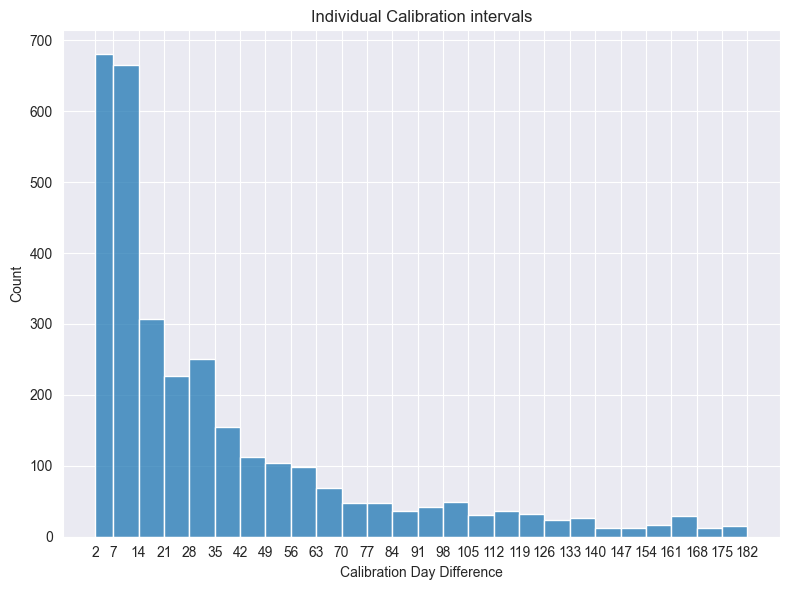

In [363]:
custom_bins = [2, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175, 182]

# Plot histogram with custom bins
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df_pH,
    x='pH_org_Calibration_Diff_Days',
    bins=custom_bins
)
plt.xticks(custom_bins)
plt.xlabel('Calibration Day Difference')
plt.ylabel('Count')
plt.title('Individual Calibration intervals')
plt.tight_layout()
plt.show()

##### Saving df_pH

In [364]:
output_path = r"C:\Users\ssasanapuri\Downloads\CalibrationFilesAsOfMay22\tRANFORMED\pH_transformed_data_REV1.xlsx"
df_pH.to_excel(output_path, index=True)

##### Read df_pH data

In [383]:
input_path = r"C:\Users\ssasanapuri\Downloads\CalibrationFilesAsOfMay22\tRANFORMED\pH_transformed_data_REV1.xlsx"
df_pH = pd.read_excel(input_path, sheet_name='Sheet1')

The data seems to follow exponential distribution if we plot histogram on individual calibration intervals weekwise. Checking for this same distribution pattern after plotting mean/median of calibration intervals at device level

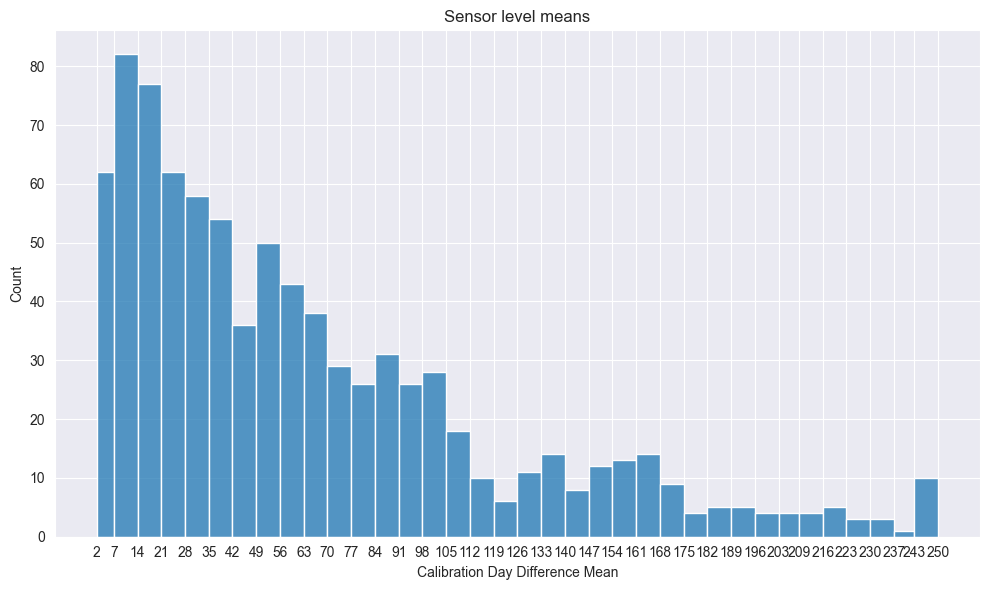

In [384]:
custom_bins = [2, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175, 182, 189, 196, 203, 209, 216, 223, 230, 237, 243, 250]

plt.figure(figsize=(10, 6))
sns.histplot(

    x=df_pH.groupby(by='pH_Serial_Number')['pH_org_Calibration_Diff_Days'].agg(['median', 'mean', 'max', 'count']).reset_index()['mean'],
    bins=custom_bins)
plt.xticks(custom_bins)
plt.xlabel('Calibration Day Difference Mean')
plt.ylabel('Count')
plt.title('Sensor level means')
plt.tight_layout()
plt.show()

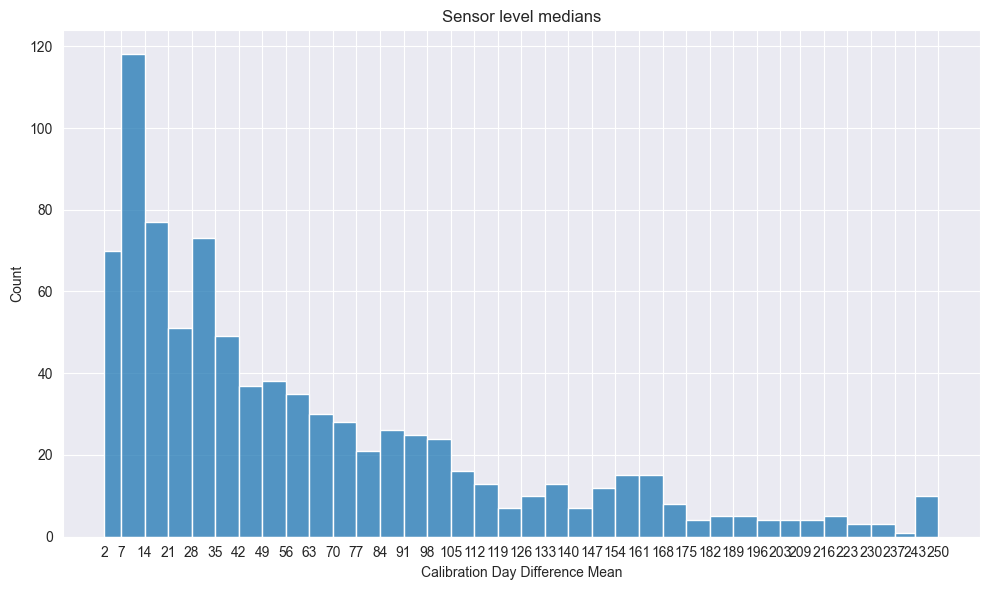

In [385]:
plt.figure(figsize=(10, 6))
sns.histplot(

    x=df_pH.groupby(by='pH_Serial_Number')['pH_org_Calibration_Diff_Days'].agg(['median', 'mean', 'max', 'count']).reset_index()['median'],
    bins=custom_bins)
plt.xticks(custom_bins)
plt.xlabel('Calibration Day Difference Mean')
plt.ylabel('Count')
plt.title('Sensor level medians')
plt.tight_layout()
plt.show()

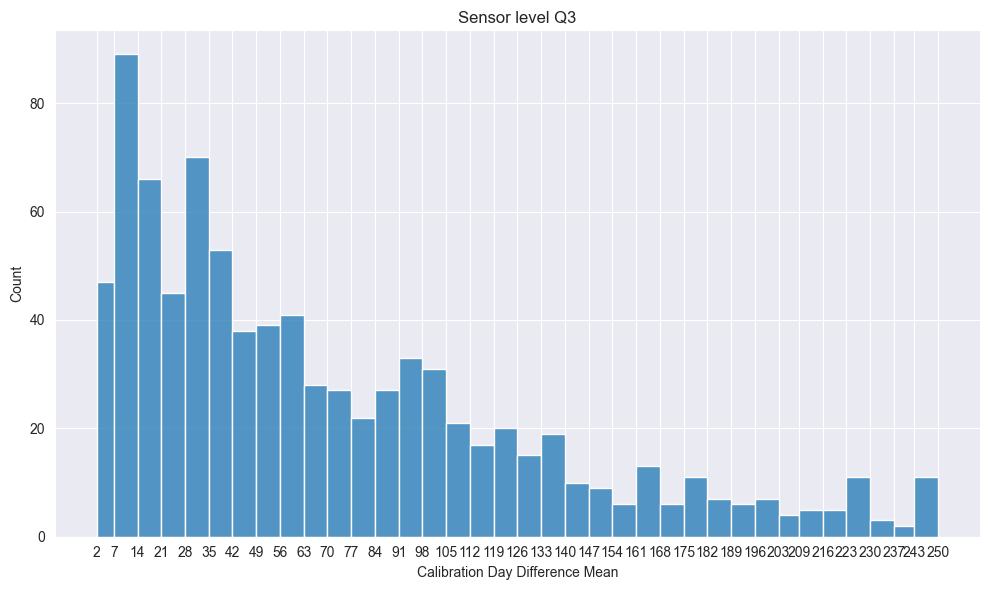

In [386]:
plt.figure(figsize=(10, 6))
sns.histplot(
    x=df_pH.groupby(by='pH_Serial_Number')['pH_org_Calibration_Diff_Days'].quantile(0.75).reset_index()['pH_org_Calibration_Diff_Days'],
    bins=custom_bins)
plt.xticks(custom_bins)
plt.xlabel('Calibration Day Difference Mean')
plt.ylabel('Count')
plt.title('Sensor level Q3')
plt.tight_layout()
plt.show()

In [387]:
df_pH['Calibration_Diff_75th_Percentile'] = (
    df_pH.groupby('pH_Serial_Number')['pH_org_Calibration_Diff_Days']
         .transform(lambda x: x.quantile(0.75)))

df_pH['Calibration_Diff_Median'] = df_pH.groupby(by='pH_Serial_Number')['pH_org_Calibration_Diff_Days'].transform(lambda x: x.median())

df_pH['Calibration_Diff_Mean'] = df_pH.groupby(by='pH_Serial_Number')['pH_org_Calibration_Diff_Days'].transform(lambda x: x.mean())



C:\Users\ssasanapuri\PyCharmMiscProject\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ssasanapuri\PyCharmMiscProject\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ssasanapuri\PyCharmMiscProject\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ssasanapuri\PyCharmMiscProject\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ssasanapuri\PyCharmMiscProject\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ssasanapuri\PyCh

In [388]:
df_pH['Calibration_Diff_Count'] = df_pH.groupby(by='pH_Serial_Number')['pH_org_Calibration_Diff_Days'].transform(lambda x: x.count())


In [389]:
df_pH

,Unnamed: 0,Instrument,Serial Number,Created,File_ID,Folder,File_Name,pH_org_duplicate,pH_org_Last_Calibrated_Date,pH_org_Calibration_Point_1_pH_of_Buffer,...,pH_org_Calibration_Point_3_Temperature,pH_org_Slope_and_Offset_2_Slope,pH_org_Slope_and_Offset_2_Offset,pH_org_Calibration_Details_Total_Calibration_Points,pH_Serial_Number,pH_org_Calibration_Diff_Days,Calibration_Diff_75th_Percentile,Calibration_Diff_Median,Calibration_Diff_Mean,Calibration_Diff_Count
0,5,SmarTROLL MP,406965,01/04/2025,406965\1743508100935-5597823059951616-VuSitu_C...,406965,1743508100935-5597823059951616-VuSitu_Calibrat...,False,2025-04-01,7.02,...,NaN,NaN,NaN,1,16628,NaN,NaN,NaN,NaN,0
1,7,Aqua TROLL 400,851413,8/15/2024,851413\1723720073017-4533799053295616-VuSitu_C...,851413,1723720073017-4533799053295616-VuSitu_Calibrat...,False,2024-08-15,4.00,...,28.07,-56.79,-1.6,3,17667,NaN,NaN,NaN,NaN,0
2,8,Aqua TROLL 400,732247,2024. 09. 09.,732247\1725875797981-4890074064748544-VuSitu_C...,732247,1725875797981-4890074064748544-VuSitu_Calibrat...,False,2024-09-09,4.00,...,25.87,-15.49,22.3,3,18336,NaN,NaN,NaN,NaN,0
3,9,Aqua TROLL 400,621216,26/11/2024,621216\1732617589115-5859457182334976-VuSitu_C...,621216,1732617589115-5859457182334976-VuSitu_Calibrat...,False,2024-11-26,7.04,...,NaN,NaN,NaN,1,20064,NaN,NaN,NaN,NaN,0
4,15,Aqua TROLL 400,621216,23/1/2025,621216\1737630597749-6742020447928320-VuSitu_C...,621216,1737630597749-6742020447928320-VuSitu_Calibrat...,False,2025-01-23,7.04,...,NaN,NaN,NaN,2,20065,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4937,9352,Aqua TROLL 600,1206247,4/11/2025,1206247\1744375828956-5835401013035008-VuSitu_...,1206247,1744375828956-5835401013035008-VuSitu_Calibrat...,False,2025-04-11,7.00,...,NaN,NaN,NaN,1,1188358,2.0,8.0,6.0,6.0,2
4938,9354,Aqua TROLL 600,1206247,4/21/2025,1206247\1745235787908-6672834004844544-VuSitu_...,1206247,1745235787908-6672834004844544-VuSitu_Calibrat...,False,2025-04-21,4.00,...,24.93,-57.32,3.1,3,1188358,10.0,8.0,6.0,6.0,2
4939,9357,Aqua TROLL 800,1047997,04/04/2025,1047997\1743752633084-4863864915165184-VuSitu_...,1047997,1743752633084-4863864915165184-VuSitu_Calibrat...,False,2025-04-04,4.00,...,22.54,-58.26,2.5,3,1188376,NaN,NaN,NaN,NaN,0
4940,9359,Aqua TROLL 600,1212741,4/16/2025,1212741\1744809058907-4664667603533824-VuSitu_...,1212741,1744809058907-4664667603533824-VuSitu_Calibrat...,False,2025-04-16,7.02,...,NaN,NaN,NaN,1,1188401,NaN,12.0,12.0,12.0,1


In [437]:
df_pH_clean = df_pH[~df_pH.duplicated(subset = ['pH_Serial_Number'], keep='last')][['Instrument', 'Serial Number', 'pH_Serial_Number', 'pH_org_Calibration_Diff_Days', 'Calibration_Diff_Median', 'Calibration_Diff_Mean', 'Calibration_Diff_Count']].dropna()
df_pH_clean

,Instrument,Serial Number,pH_Serial_Number,pH_org_Calibration_Diff_Days,Calibration_Diff_Median,Calibration_Diff_Mean,Calibration_Diff_Count
11,Aqua TROLL 400,965586,20239,16.0,16.0,36.800000,5
14,Aqua TROLL 400,658539,20338,683.0,683.0,683.000000,1
19,Aqua TROLL 400,678545,20744,27.0,30.5,33.000000,4
23,Aqua TROLL 400,727443,20769,7.0,19.0,15.333333,3
47,Aqua TROLL 400,731884,20812,14.0,7.0,11.217391,23
...,...,...,...,...,...,...,...
4895,Aqua TROLL 500,1196527,1113430,12.0,7.0,8.428571,7
4902,Aqua TROLL 600,956051,1113481,49.0,8.0,20.666667,3
4912,Aqua TROLL 600,1181449,1188046,58.0,58.0,58.000000,1
4938,Aqua TROLL 600,1206247,1188358,10.0,6.0,6.000000,2


#### Hypothesis testing

##### Null Hypothesis: There is no difference in means of pH calibration intervals between any two types of instruments
##### Alternate Hypothesis: Means of calibration interval of all instruments types are not same and are statistically different from each other

In [410]:
troll_nums = [400, 500, 600, 700, 800, 'SmarTROLL MP']
troll_groups = {}

for troll in troll_nums:
    if isinstance(troll, int):
        troll_str = str(troll)
    else:
        troll_str = troll

    troll_groups[f'at{troll_str}'] = df_pH_clean[
        (df_pH_clean['Instrument'] == f'Aqua TROLL {troll_str}') |
        (df_pH_clean['Instrument'] == f'Aqua TROLL {troll_str} Vented') |
        (df_pH_clean['Instrument'] == troll_str)
    ]['Calibration_Diff_Mean']

In [422]:
for group in troll_groups.keys():
    print(shapiro(troll_groups[group]))

ShapiroResult(statistic=np.float64(0.6152926783384629), pvalue=np.float64(9.299229700434882e-14))
ShapiroResult(statistic=np.float64(0.7280135108721657), pvalue=np.float64(7.411259501304417e-23))
ShapiroResult(statistic=np.float64(0.4057466852322037), pvalue=np.float64(1.6663884461216035e-35))
ShapiroResult(statistic=np.float64(0.8264418241253766), pvalue=np.float64(8.689600455578479e-05))
ShapiroResult(statistic=np.float64(0.35568011507205366), pvalue=np.float64(1.2135792036832943e-08))
ShapiroResult(statistic=np.float64(0.7985491333127507), pvalue=np.float64(0.09964312773360977))


Above p values suggest that none of the distributions are normal and can't apply t-test or Z-test except for smartroll

In [434]:
for i in range(len(troll_groups.keys())-1):
    for j in range(i+1, len(troll_groups.keys())-1):
        u_stat, p_val = mannwhitneyu(troll_groups[list(troll_groups.keys())[i]], troll_groups[list(troll_groups.keys())[j]], alternative='two-sided')
        print(f"Hypothesis test for {list(troll_groups.keys())[i]} & {list(troll_groups.keys())[j]}- U-statistic: {u_stat:.4f}, p-value: {p_val:.4f}")

Hypothesis test for at400 & at500- U-statistic: 12672.0000, p-value: 0.0925
Hypothesis test for at400 & at600- U-statistic: 18101.0000, p-value: 0.4423
Hypothesis test for at400 & at700- U-statistic: 904.0000, p-value: 0.0009
Hypothesis test for at400 & at800- U-statistic: 619.5000, p-value: 0.0227
Hypothesis test for at500 & at600- U-statistic: 77426.5000, p-value: 0.1016
Hypothesis test for at500 & at700- U-statistic: 4206.0000, p-value: 0.0163
Hypothesis test for at500 & at800- U-statistic: 2801.0000, p-value: 0.1411
Hypothesis test for at600 & at700- U-statistic: 5105.0000, p-value: 0.0021
Hypothesis test for at600 & at800- U-statistic: 3504.5000, p-value: 0.0635
Hypothesis test for at700 & at800- U-statistic: 388.5000, p-value: 0.5912


when p-value is > 0.05 we fail to reject null hypothesis. There is no statistically significant evidence for alternate hypothesis. That means for H0 to be true, it should be significant enough. General accepted level of significance is 5%. So, we see which combination has p-value lower than 0.05. at400, 700 | at400, 800 | at500, 700 | at600, 700 - All these combinations, we reject the claim made in Null Hypothesis ans say that there is statistically significant evidence that mean calibration intervals b/w these instrument types is not same.

We excluded smartroll MP in above tests because p-value obtained from shapiro test > 0.05 and indicates that it is a normal distribution. Let's see the histplot

In [ ]:
for group in troll_groups.keys():

    plt.figure(figsize=(10, 6))
    sns.histplot(x=troll_groups[group], bins=custom_bins)
    plt.xticks(custom_bins)
    plt.xlabel('Calibration Day Difference Mean')
    plt.ylabel('Count')
    plt.title(f'Instrument Type {group}')
    plt.tight_layout()
    plt.show()

Samrtroll has just 4 unique sensors; not much data for any test

##### Mixed Model Effect

How much variation of pH calibration intervals is explained by grouping of instruments??

In [435]:
# Fit mixed-effects model
model = smf.mixedlm("Calibration_Diff_Mean ~ 1", data=df_pH_clean, groups=df_pH_clean["Instrument"])
result = model.fit()
print(result.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Calibration_Diff_Mean
No. Observations: 918     Method:             REML                 
No. Groups:       11      Scale:              14166.5589           
Min. group size:  3       Log-Likelihood:     -5691.5201           
Max. group size:  328     Converged:          Yes                  
Mean group size:  83.5                                             
---------------------------------------------------------------------
                 Coef.    Std.Err.     z     P>|z|   [0.025    0.975]
---------------------------------------------------------------------
Intercept        90.245      9.206   9.803   0.000   72.201   108.289
Group Var       443.760      3.481                                   



The high value in Group Var indicates that there is difference in means across instrument types, but the value in Scale is multi-fold times higher than Group Var. If the value of Scale is relatively lower than Group Var , then most of the variation would have been attributable to grouping.

We are modelling the random effect of instrument type on calibration intervals. As we know that it does not make any effect whether which troll we use for sensor readings, the same is proven here with this test. Instrument type has influenced variance of pH calibration intervals by ~3.04% (ICC= 443.760/443.760+14166.5589 = 0.0304), which is very negligible. The remaining 97% of the variance is due to within-group variability — so most of the variation is not attributable to the grouping structure. Calibration behavior is highly variable even within the same instrument.



Let us see the distribution of pH_slope-1 & offset values. As per the manual, slope should be in range of +/-30 mV offset, slope -66 to 50

In [438]:
df_pH.columns

Index(['Unnamed: 0', 'Instrument', 'Serial Number', 'Created', 'File_ID',
       'Folder', 'File_Name', 'pH_org_duplicate',
       'pH_org_Last_Calibrated_Date',
       'pH_org_Calibration_Point_1_pH_of_Buffer',
       'pH_org_Calibration_Point_1_pH_mV',
       'pH_org_Calibration_Point_1_Temperature', 'pH_org_Pre_Measurement_pH',
       'pH_org_Pre_Measurement_pH_mV', 'pH_org_Post_Measurement_pH',
       'pH_org_Post_Measurement_pH_mV', 'pH_org_Slope_and_Offset_1_Slope',
       'pH_org_Slope_and_Offset_1_Offset',
       'pH_org_Calibration_Point_2_pH_of_Buffer',
       'pH_org_Calibration_Point_2_pH_mV',
       'pH_org_Calibration_Point_2_Temperature',
       'pH_org_Calibration_Point_3_pH_of_Buffer',
       'pH_org_Calibration_Point_3_pH_mV',
       'pH_org_Calibration_Point_3_Temperature',
       'pH_org_Slope_and_Offset_2_Slope', 'pH_org_Slope_and_Offset_2_Offset',
       'pH_org_Calibration_Details_Total_Calibration_Points',
       'pH_Serial_Number', 'pH_org_Calibration_Diff_Days

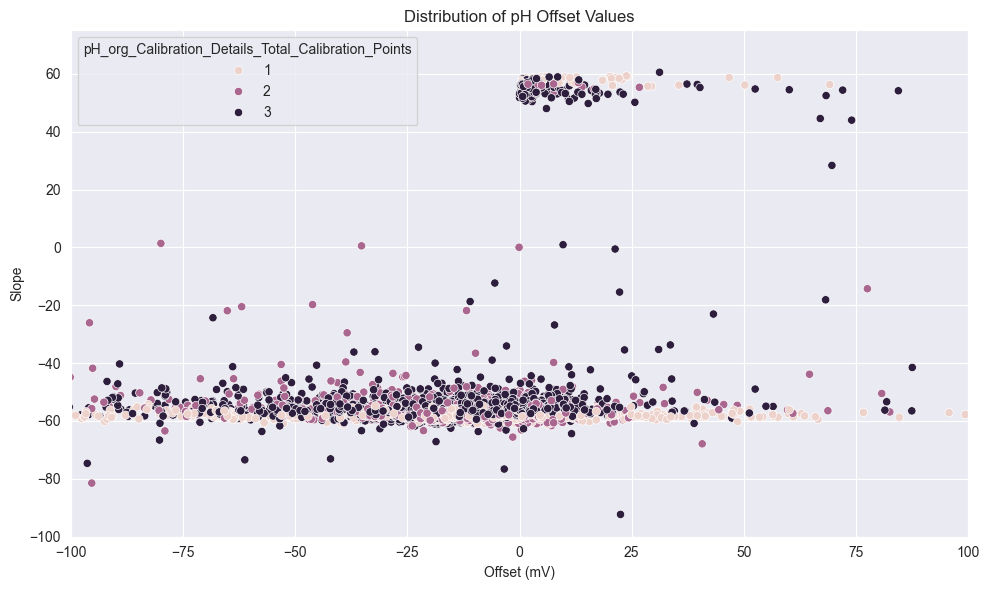

In [452]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = df_pH, x=df_pH['pH_org_Slope_and_Offset_1_Offset'], y = df_pH['pH_org_Slope_and_Offset_1_Slope'], hue='pH_org_Calibration_Details_Total_Calibration_Points')
plt.xlim(-100, 100)
plt.ylim(-100, 75)
plt.xlabel("Offset (mV)")
plt.ylabel("Slope")
plt.title("Distribution of pH Offset Values")
plt.grid(True)
plt.tight_layout()
plt.show()

Slope was calculated as positive for certain data points, instead of negative relationshio. Also, though VuSitu detected pH as 4, the actual readings show near 9-10. So, there is something fishy and a backward calculation is done i.e., in reverse direction

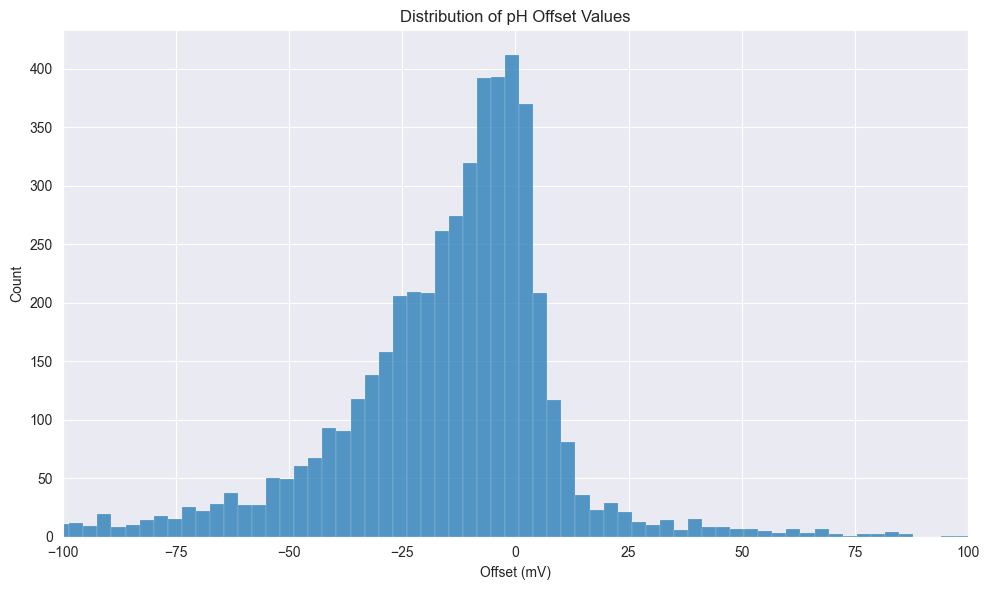

In [454]:
plt.figure(figsize=(10, 6))
sns.histplot(data = df_pH, x=df_pH['pH_org_Slope_and_Offset_1_Offset'])
plt.xlim(-100, 100)
plt.xlabel("Offset (mV)")
plt.ylabel("Count")
plt.title("Distribution of pH Offset Values")
plt.grid(True)
plt.tight_layout()
plt.show()

If we remove above positive slope values, rest all are negative.

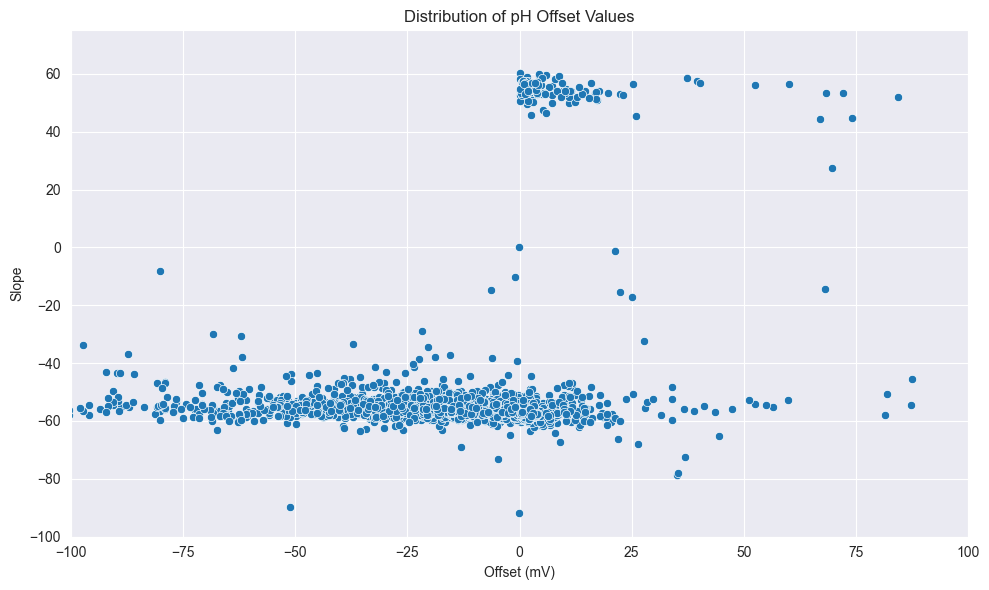

In [456]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = df_pH, x=df_pH['pH_org_Slope_and_Offset_2_Offset'], y = df_pH['pH_org_Slope_and_Offset_2_Slope'])
plt.xlim(-100, 100)
plt.ylim(-100, 75)
plt.xlabel("Offset (mV)")
plt.ylabel("Slope")
plt.title("Distribution of pH Offset Values")
plt.grid(True)
plt.tight_layout()
plt.show()